<span style="color:blue; font-size:24px;"><b>LSA analysis of university complaints</b></span>

<span style="color:orange; font-size:18px;"><b>0. Loading the data</b></span>

In [1]:
import os
import sys
import pandas as pd

# Project root path
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(BASE_DIR)

DATA_PATH = os.path.join(BASE_DIR, "data", "raw", "Datasetprojpowerbi.csv")
df = pd.read_csv(DATA_PATH)

texts = df["Reports"].tolist()
print(f"Loaded {len(texts)} docs.")

Loaded 1005 docs.


<span style="color:orange; font-size:18px;"><b>1. Cleaning and tokenizing</b></span>

In [2]:
from src.preprocessing.clean_text import normalize_texts, lemmatize_and_tokenize, apply_bigrams

# 1. Normalization
cleaned_texts = normalize_texts(texts)

# 2. Lemmatization and tokenization
tokenized_texts = lemmatize_and_tokenize(cleaned_texts)

# 3. N-gramms
corpus_tokens = apply_bigrams(tokenized_texts)

print(f"Cleaned and tokenized {len(corpus_tokens)} docs.")

Cleaned and tokenized 1005 docs.


<span style="color:orange; font-size:18px;"><b>2. Creating dictionary and TF-IDF corpus (better than BoW for LSA)</b></span>

In [8]:
from src.vectorization.vecorize_lsa_lda import build_dictionary, build_corpus

# Creating dictionary for the corpus
dictionary = build_dictionary(corpus_tokens)

# Creating TF-IDF corpus
tfidf_corpus, tfidf_model = build_corpus(corpus_tokens, dictionary, vector_type="tfidf")

print(f"TF-IDF corpus of {len(tfidf_corpus)} docs created.")

TF-IDF corpus of 1005 docs created.


<span style="color:orange; font-size:18px;"><b>3. Training LSA models for diff number of topics and calculate c_v and WETC coherence scores </b></span>

In [9]:
from src.topic_models.lsa_lda_models import train_lsa, print_topics
from src.metrics.wetc import wetc
from gensim.models import CoherenceModel
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

for num_topics in range(3,16):
    lsa_model = train_lsa(tfidf_corpus, dictionary, num_topics=num_topics)
    lsa_topics = lsa_model.show_topics(num_words=10, formatted=False)
    topics = [[word for word, weight in topic] for topic_id, topic in lsa_topics]
    
    coherence_model = CoherenceModel(
        topics=topics,
        texts=corpus_tokens,        
        dictionary=dictionary,
        coherence='c_v',        
        window_size=10    # =< 0.5 x median length of docs (20) 
    )

    cv_score = coherence_model.get_coherence()
    wetc_score = wetc(topics)
    waver = 0.7 * wetc_score + 0.3 * cv_score
    print(f"Num topics: {num_topics}, C_v: {cv_score:.3f},  WETC: {wetc_score:.3f}, Average: {waver:.3f}")


Num topics: 3, C_v: 0.314,  WETC: 0.598, Average: 0.513
Num topics: 4, C_v: 0.311,  WETC: 0.593, Average: 0.508
Num topics: 5, C_v: 0.335,  WETC: 0.592, Average: 0.515
Num topics: 6, C_v: 0.327,  WETC: 0.594, Average: 0.514
Num topics: 7, C_v: 0.368,  WETC: 0.591, Average: 0.524
Num topics: 8, C_v: 0.365,  WETC: 0.592, Average: 0.524
Num topics: 9, C_v: 0.367,  WETC: 0.591, Average: 0.523
Num topics: 10, C_v: 0.344,  WETC: 0.592, Average: 0.517
Num topics: 11, C_v: 0.362,  WETC: 0.591, Average: 0.523
Num topics: 12, C_v: 0.362,  WETC: 0.590, Average: 0.522
Num topics: 13, C_v: 0.358,  WETC: 0.589, Average: 0.520
Num topics: 14, C_v: 0.378,  WETC: 0.588, Average: 0.525
Num topics: 15, C_v: 0.379,  WETC: 0.588, Average: 0.526


<span style="color:orange; font-size:18px;"><b>4. Word cloud for 15 topics</b></span>

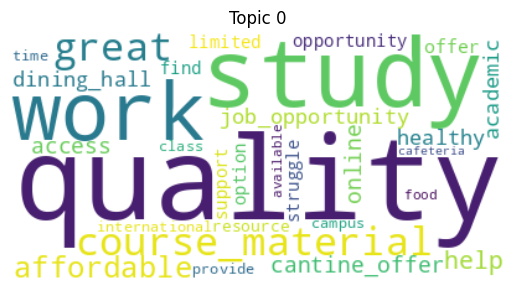

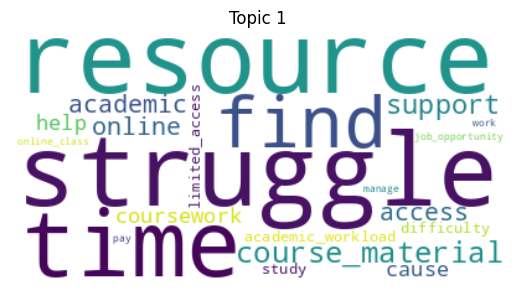

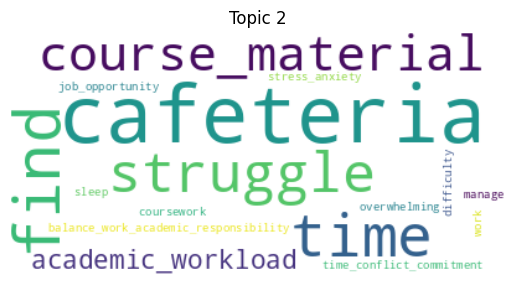

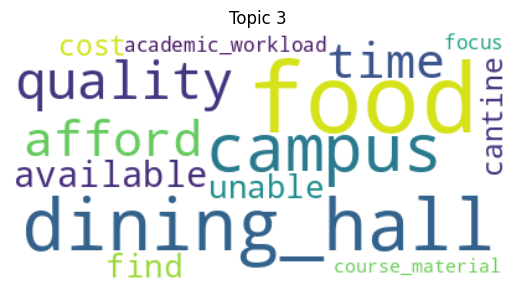

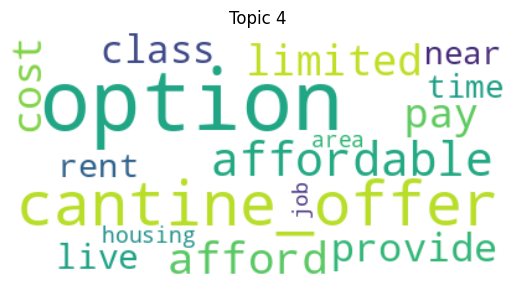

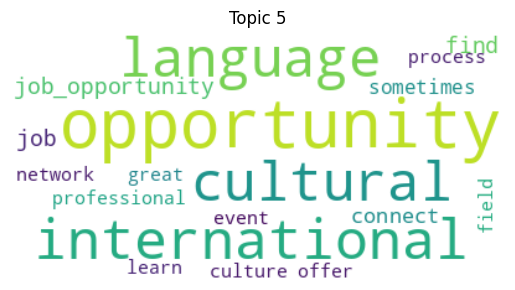

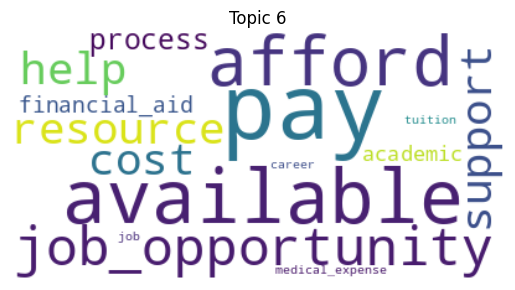

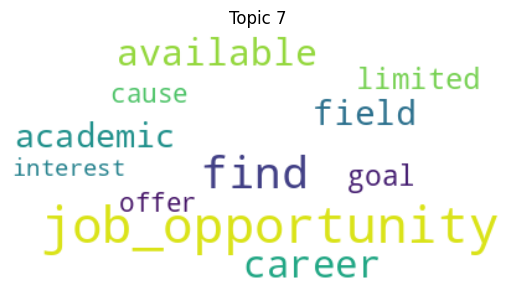

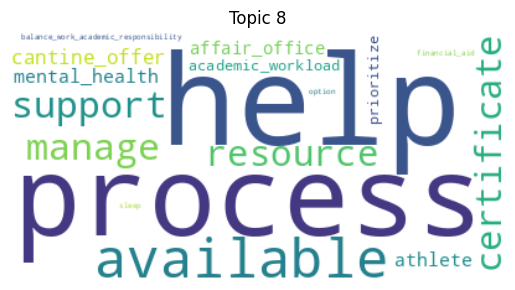

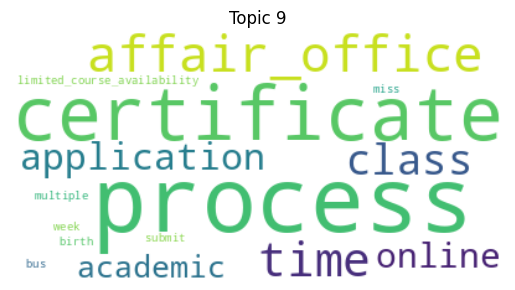

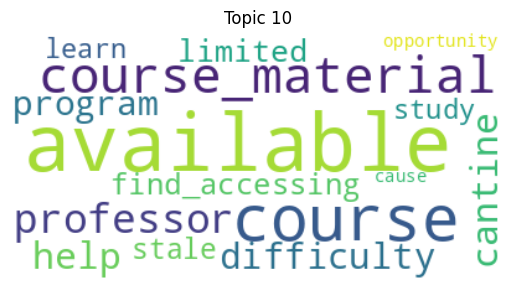

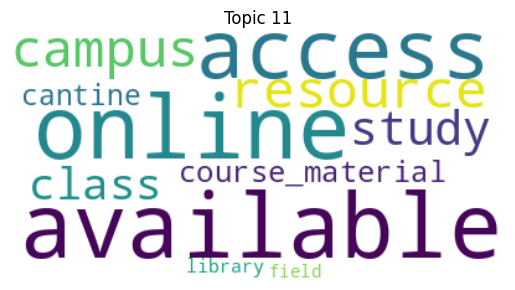

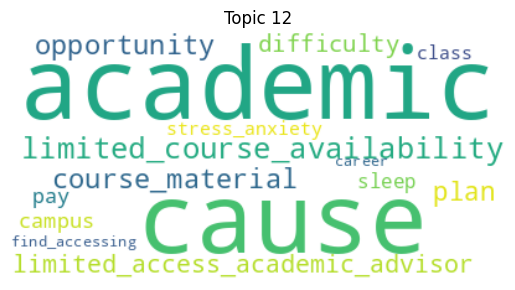

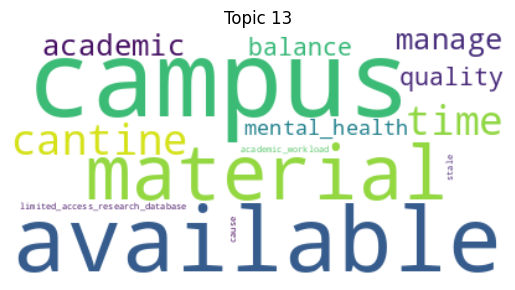

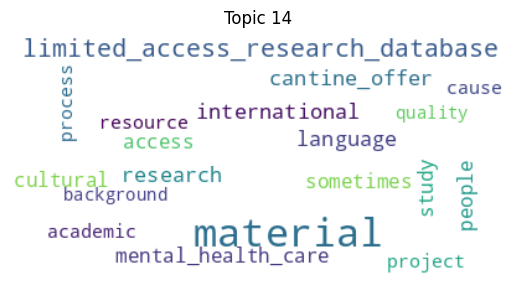

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

lsa_model = train_lsa(tfidf_corpus, dictionary, num_topics=15)
for topic_id, topic in lsa_model.show_topics(num_words=30, formatted=False):
    topic_words = dict(topic)
    wc = WordCloud(width=400, height=200, background_color="white").generate_from_frequencies(topic_words)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_id}")
    plt.show()